### Further clean SPEND & PAYMENT variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from itertools import compress
from pandarallel import pandarallel
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PowerTransformer
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, print_percentile,
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, check_psi, plot_heatmap
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, check_roc_auc,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

36

In [6]:
START = time.time()

### Read Data

In [7]:
%%time
train = read_file(f"../{RAW_TRAIN_PARQUET_PATH}/spend_payment.parquet")
test = read_file(f"../{RAW_TEST_PARQUET_PATH}/spend_payment.parquet")

Shape of data: (5531451, 26)
Shape of data: (11363762, 26)
CPU times: user 4.51 s, sys: 10.2 s, total: 14.7 s
Wall time: 13.5 s


In [8]:
%%time
labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 928 ms, sys: 641 ms, total: 1.57 s
Wall time: 2.4 s


In [9]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 2.94 s, sys: 3.1 s, total: 6.03 s
Wall time: 10.4 s


In [10]:
del test

In [11]:
train.shape, public_test.shape, private_test.shape

((5531451, 27), (5719469, 26), (5644293, 26))

In [12]:
print(sorted(get_cols(train, ["P_", "S_"])))

['P_2', 'P_3', 'P_4', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_2', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9']


In [13]:
train["target"].mean()

0.24909720794778803

In [14]:
df_list = [train, public_test, private_test]

In [15]:
for df in df_list:
    insert_row_number(df)

Done insertion
Done insertion
Done insertion


In [16]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
# train_corr = train.loc[:, train.columns[4:-1]].corr()
# train_corr.to_csv(f"../{RAW_DATA_PATH}/pre_clean_train_spend_payment_corr.csv", index=False)

In [18]:
# train_corr = read_file(f"../{RAW_DATA_PATH}/pre_clean_train_spend_payment_corr.csv")
# train_corr.index = train_corr.columns

In [19]:
# plot_heatmap(train_corr, figsize=(19, 12), fmt=".2f", annot=True)

### P_2 (Done)

In [20]:
# plot_target_check(train, "P_2", q=50, use_raw_bin=True)

In [21]:
%%time
df_list = round_dfs(df_list, col="P_2", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0205
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0045
CPU times: user 2.54 s, sys: 2.87 s, total: 5.41 s
Wall time: 13.9 s


In [22]:
describe_all(df_list, "P_2")

,train,public test,private test
count,"5,485,466.0000","5,685,852.0000","5,618,032.0000"
mean,0.6513,0.6501,0.6553
std,0.2447,0.2475,0.2463
min,-0.4600,-0.4400,-0.4700
25%,0.4800,0.4800,0.4900
50%,0.6900,0.6900,0.7000
75%,0.8600,0.8600,0.8600
max,1.0000,1.0000,1.0000
null_proportion,0.0083,0.0059,0.0047


In [23]:
print_percentile(df_list, "P_2", 0.01)

0.01th percentile:
train : -0.29
public test : -0.29
private test : -0.28


In [24]:
for df in df_list:
    df = clip_col(df, "P_2", btm_value=-0.29, add_new_col=False)

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1


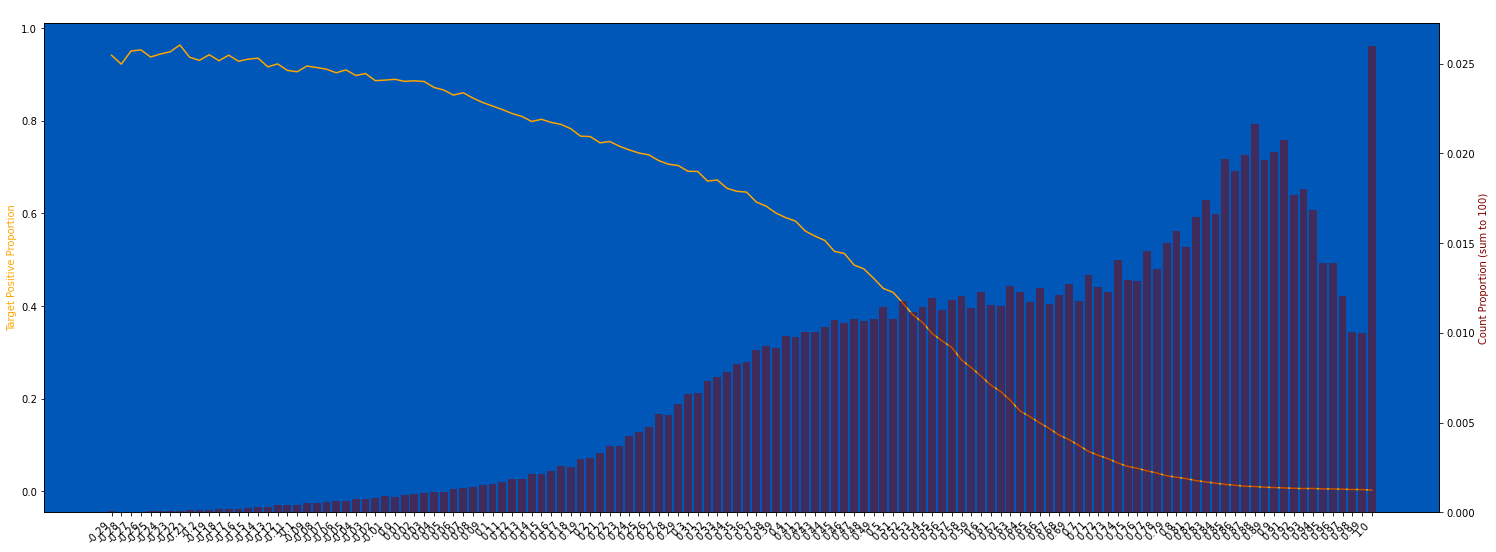

In [25]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True, nunique_thr=150, strfy_x=True, figsize=(25, 10), without_drop_tail=True)

In [26]:
# plot_train_test_distribution(df_list, "P_2", nunique_thr=150, figsize=(24, 9), without_drop_tail=True)

### P_3a (Created)

In [27]:
# for p in np.arange(2.8, 4, 0.05):
#     def calc(x):
#         if x >= 0.618:
#             return (x - 0.618) / p
#         else:
#             return (0.618 - x)

#     for df in df_list:
#         df["P_3a"] = df["P_3"].parallel_apply(lambda x: calc(x)).round(2)
        
#     print(p, check_roc_auc(train, "P_3a"))

In [28]:
def calc(x):
    p = 0.624
    q = 4
    if x >= p:
        return (x - p) / q
    else:
        return (p - x)

In [29]:
for df in df_list:
    df["P_3a"] = df["P_3"].parallel_apply(lambda x: calc(x)).round(2)
    df = clip_col(df, "P_3a", add_new_col=False, top_value=1)

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


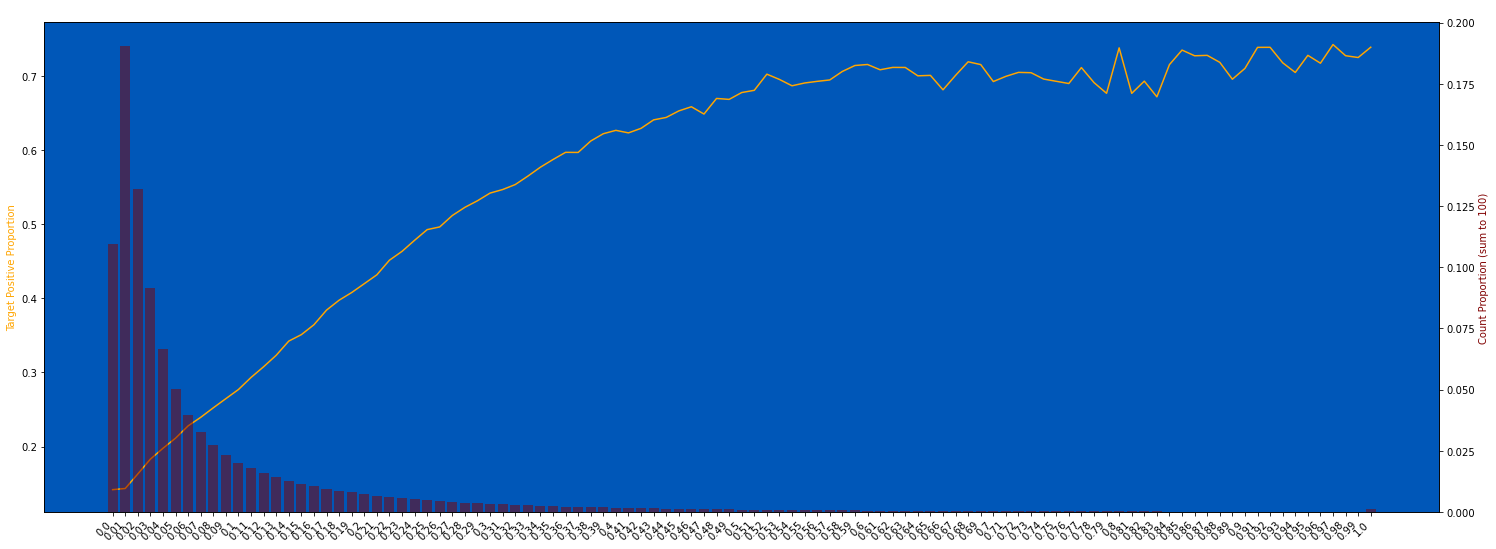

In [30]:
plot_target_check(train, "P_3a", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, 
                  figsize=(25, 10), without_drop_tail=True)

In [31]:
# plot_train_test_distribution(df_list, "P_3a", nunique_thr=340, figsize=(24, 10), without_drop_tail=True)

### P_3 (Done)

In [32]:
# plot_target_check(train, "P_3", q=50, use_raw_bin=True)

In [33]:
%%time
df_list = round_dfs(df_list, col="P_3", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0466
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0175
CPU times: user 2.65 s, sys: 2.1 s, total: 4.75 s
Wall time: 10.1 s


In [34]:
print_percentile(df_list, "P_3", 99.6)
describe_all(df_list, "P_3")

99.6th percentile:
train : 1.11
public test : 1.11
private test : 1.11


,train,public test,private test
count,"5,229,959.0000","5,477,221.0000","5,437,962.0000"
mean,0.5963,0.5937,0.5942
std,0.1708,0.1726,0.1709
min,-1.5200,-1.5100,-1.4300
25%,0.5400,0.5300,0.5300
50%,0.6100,0.6100,0.6100
75%,0.6800,0.6800,0.6800
max,2.4200,2.6300,2.4800
null_proportion,0.0545,0.0424,0.0366


In [35]:
for df in df_list:
    df = clip_col(df, "P_3", top_value=1.11, add_new_col=False)
    df = clip_col(df, "P_3", btm_value=-0.39, add_new_col=False)

In [36]:
for df in df_list:
    df["P_3"] += 0.39

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


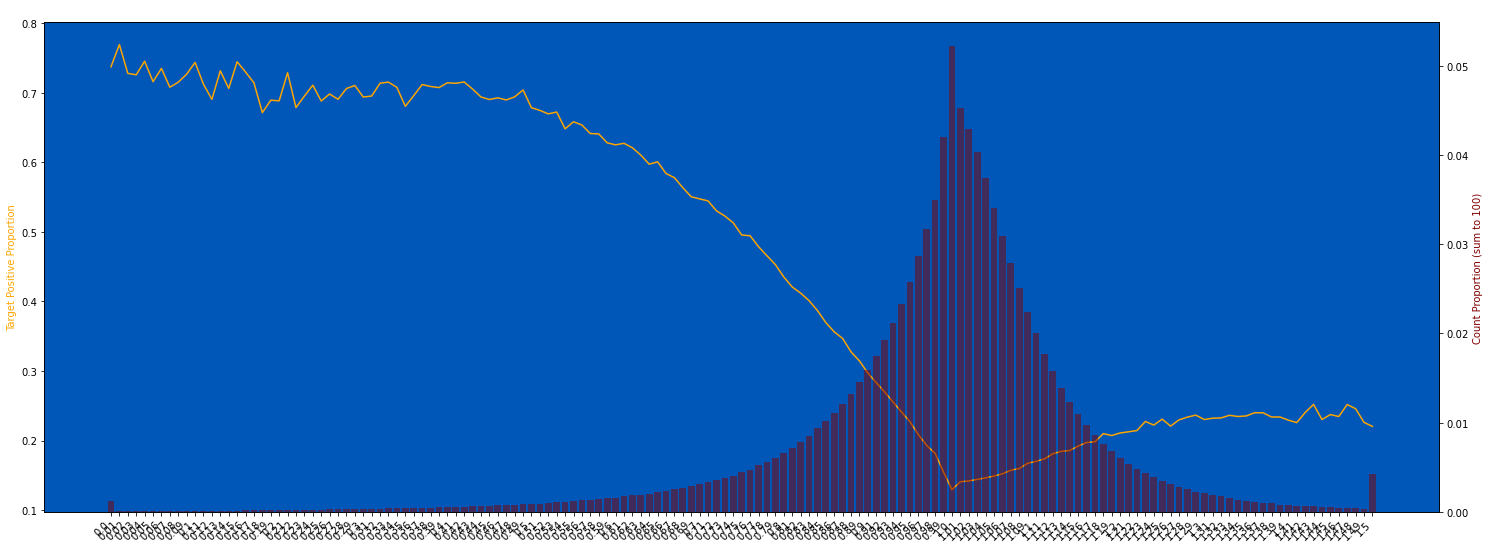

In [37]:
plot_target_check(train, "P_3", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, 
                  figsize=(25, 10), percentile_drop=2)

In [38]:
# plot_train_test_distribution(df_list, "P_3", nunique_thr=340, figsize=(24, 10))

### P_4 (KIV) Spike in the middle

In [39]:
# plot_target_check(train, "P_4", q=50, use_raw_bin=True)

In [40]:
%%time
df_list = round_dfs(df_list, col="P_4", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1472
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0955
CPU times: user 2.25 s, sys: 2.16 s, total: 4.41 s
Wall time: 8.4 s


In [41]:
%%time
df_list = fill_nans(df_list, col="P_4", tuple_of_values=(0, 0.01), add_new_col=False)

CPU times: user 112 ms, sys: 119 ms, total: 231 ms
Wall time: 295 ms


In [42]:
for df in df_list:
    df["P_4"] -= 0.76

In [206]:
print_percentile(df_list, "P_4", 99.8)
describe_all(df_list, "P_4")

99.8th percentile:
train : 0.36000001430511475
public test : 0.3100000023841858
private test : 0.30000001192092896


,train,public test,private test
count,"798,945.0000","718,921.0000","646,073.0000"
mean,0.2023,0.1977,0.1972
std,0.0255,0.0136,0.0108
min,0.1400,0.1400,0.1400
25%,0.1900,0.1900,0.1900
50%,0.2000,0.2000,0.2000
75%,0.2000,0.2000,0.2000
max,0.3800,0.3800,0.3800
null_proportion,0.8556,0.8743,0.8855


In [207]:
for df in df_list:
    df = clip_col(df, "P_4", top_value=0.36, add_new_col=False)
    df = clip_col(df, "P_4", btm_value=0.14, add_new_col=False)

4732506 null count, 0.856 null proportion
0.2073 of the targets have label = 1


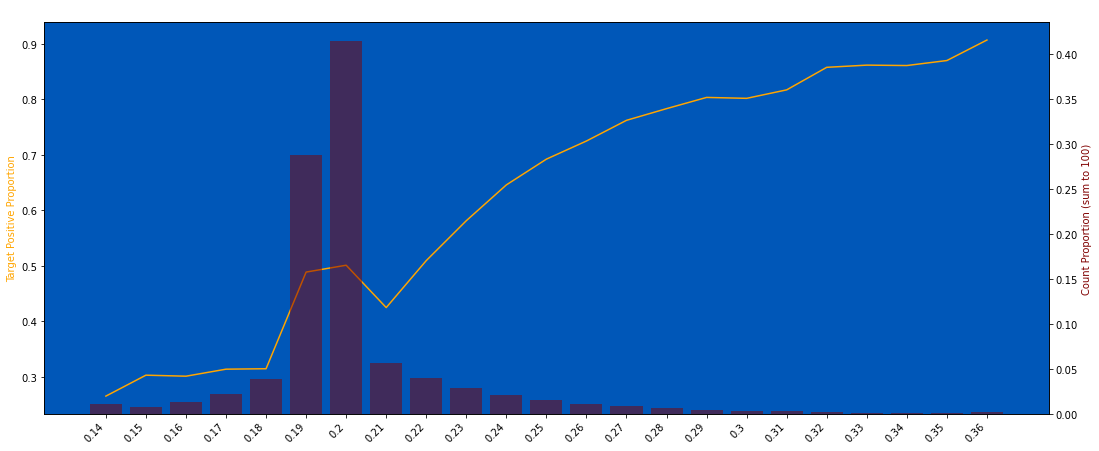

In [208]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

Train-Public PSI: 0.0578, Train-Private PSI: 0.0909


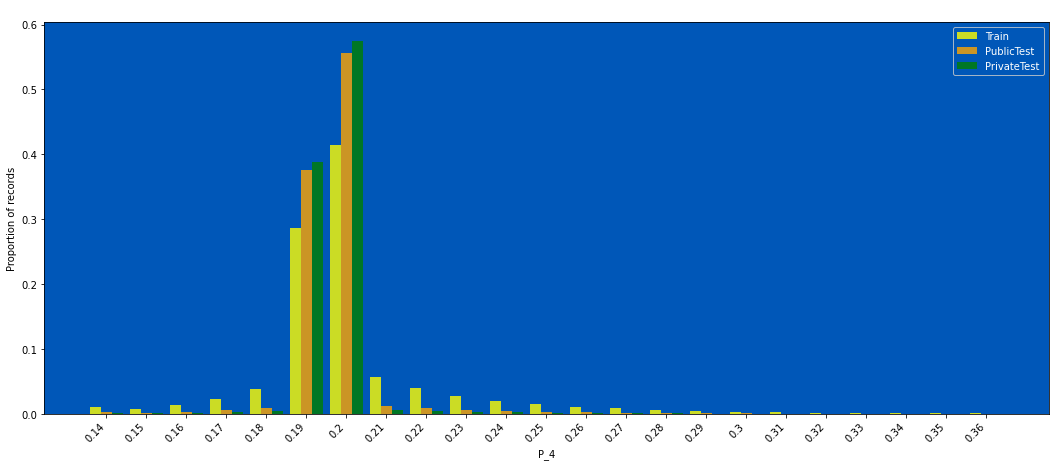

In [209]:
plot_train_test_distribution(df_list, "P_4", without_drop_tail=True)

### S_3 (Done)

In [45]:
# plot_target_check(train, "S_3", q=50, use_raw_bin=True)

In [46]:
%%time
df_list = round_dfs(df_list, col="S_3", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0690
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0480
CPU times: user 2.34 s, sys: 2.02 s, total: 4.36 s
Wall time: 7.96 s


In [47]:
print_percentile(df_list, "S_3", 0.1)
describe_all(df_list, "S_3")

0.1th percentile:
train : -0.1
public test : -0.11
private test : -0.12


,train,public test,private test
count,"4,510,907.0000","4,794,690.0000","4,828,107.0000"
mean,0.2208,0.2247,0.2201
std,0.1934,0.2005,0.1971
min,-0.6300,-0.6900,-0.6600
25%,0.1200,0.1200,0.1200
50%,0.1600,0.1600,0.1600
75%,0.2500,0.2600,0.2500
max,5.4800,4.1500,4.3400
null_proportion,0.1845,0.1617,0.1446


In [48]:
for df in df_list:
    df = clip_col(df, "S_3", top_value=1.68, add_new_col=False)
    df = clip_col(df, "S_3", btm_value=-0.12, add_new_col=False)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


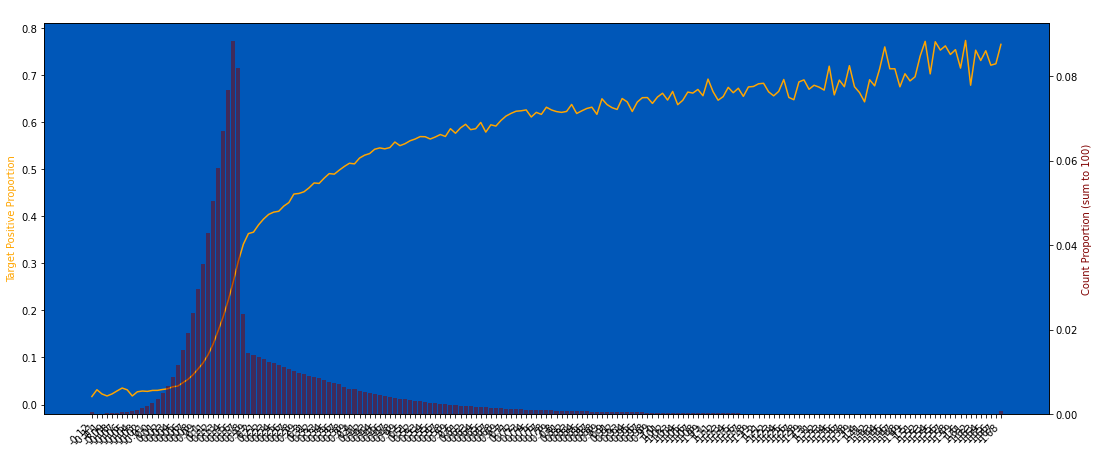

In [49]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True, nunique_thr=700, strfy_x=True, percentile_drop=0.5)

In [50]:
# plot_train_test_distribution(df_list, "S_3", nunique_thr=500)

### S_5 (Done)

In [51]:
# plot_target_check(train, "S_5", q=50, use_raw_bin=True)

In [52]:
%%time
df_list = round_dfs(df_list, col="S_5", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0705
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0706
CPU times: user 2.37 s, sys: 2.1 s, total: 4.47 s
Wall time: 8.97 s


In [53]:
print_percentile(df_list, "S_5", 99)
describe_all(df_list, "S_5")

99th percentile:
train : 1.0
public test : 1.02
private test : 1.04


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0831,0.0830,0.0839
std,0.4074,0.3772,0.5873
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0100,0.0100
75%,0.0700,0.0600,0.0600
max,206.8700,119.4300,594.8800
null_proportion,0.0000,0.0000,0.0000


In [54]:
for df in df_list:
    df = clip_col(df, "S_5", top_value=1, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


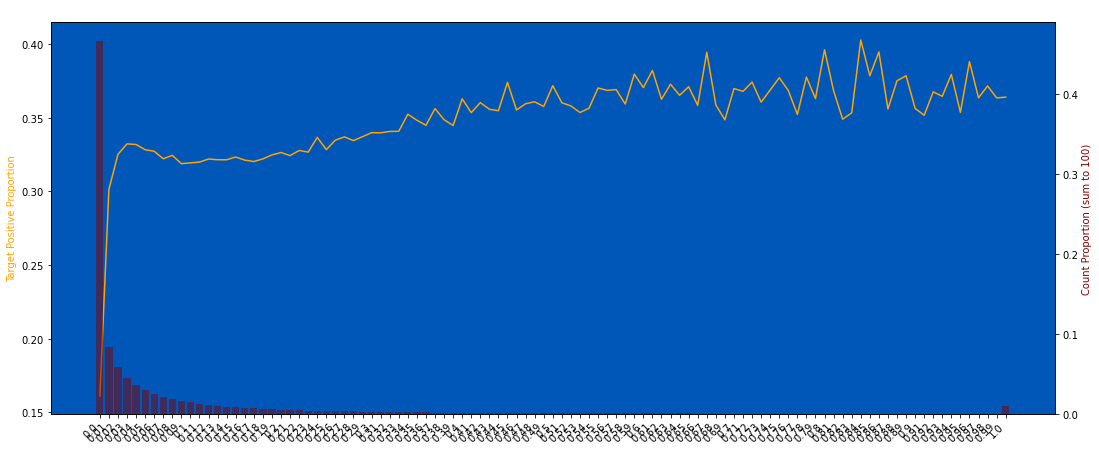

In [55]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [56]:
# plot_train_test_distribution(df_list, "S_5", nunique_thr=5000)

### S_6 (Done)

In [57]:
# plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True)

In [58]:
%%time
df_list = round_dfs(df_list, col="S_6", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0118
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0118
CPU times: user 2.26 s, sys: 1.84 s, total: 4.1 s
Wall time: 7.66 s


In [59]:
for df in df_list:
    df["S_6"] = integerize(df["S_6"])

0 null count, 0.000 null proportion
nan of the targets have label = 1


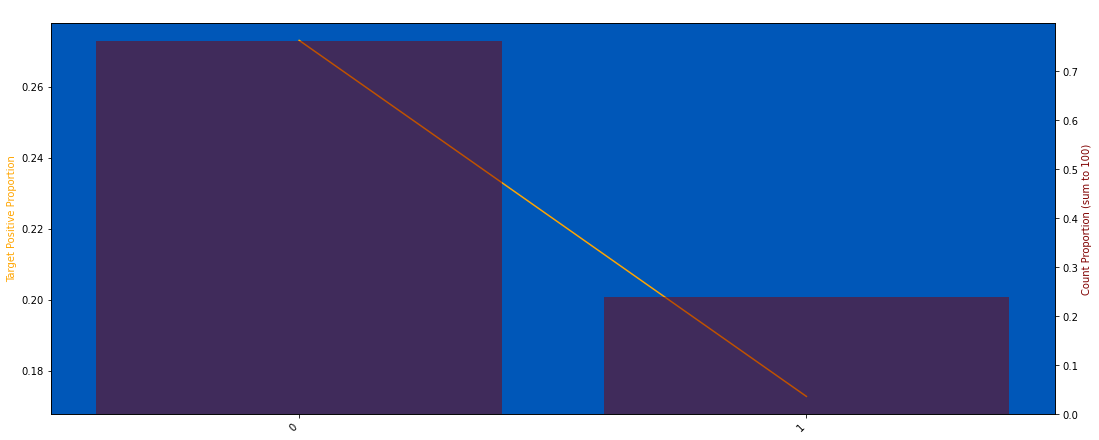

In [60]:
plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [61]:
# plot_train_test_distribution(df_list, "S_6", nunique_thr=50)

### S_7 (Done)

In [62]:
# plot_target_check(train, "S_7", q=50, use_raw_bin=True)

In [63]:
%%time
df_list = round_dfs(df_list, col="S_7", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0676
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0359
CPU times: user 2.8 s, sys: 2.36 s, total: 5.16 s
Wall time: 8.11 s


In [64]:
print_percentile(df_list, "S_7", 99.9)
describe_all(df_list, "S_7")

99.9th percentile:
train : 1.5
public test : 1.5
private test : 1.48


,train,public test,private test
count,"4,510,907.0000","4,794,690.0000","4,828,107.0000"
mean,0.2181,0.2139,0.2058
std,0.2063,0.2051,0.1982
min,-0.4800,-0.5200,-0.4900
25%,0.0900,0.0900,0.0900
50%,0.1300,0.1300,0.1200
75%,0.2900,0.2800,0.2700
max,3.9400,3.3900,3.3900
null_proportion,0.1845,0.1617,0.1446


In [65]:
for df in df_list:
    df = clip_col(df, "S_7", top_value=1.5, add_new_col=False)
    df = clip_col(df, "S_7", btm_value=-0.17, add_new_col=False)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


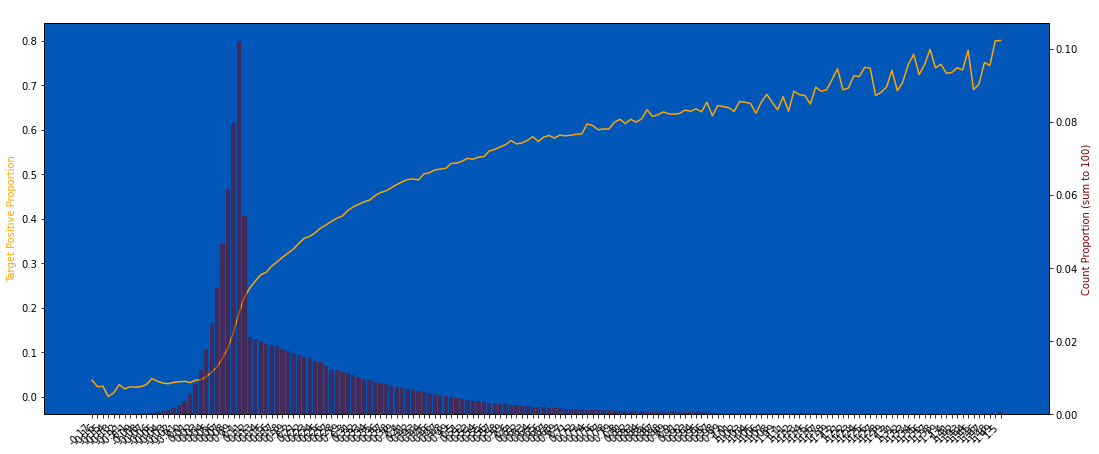

In [66]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True, nunique_thr=360, strfy_x=True)

In [67]:
# plot_train_test_distribution(df_list, "S_7", nunique_thr=5000)

### S_8 (Done)

In [68]:
# plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [69]:
%%time
df_list = round_dfs(df_list, col="S_8", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0181
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0177
CPU times: user 2.51 s, sys: 1.83 s, total: 4.34 s
Wall time: 7.18 s


In [70]:
%%time
df_list = fill_nans(df_list, col="S_8", tuple_of_values=(0), add_new_col=False)

CPU times: user 81 ms, sys: 96 ms, total: 177 ms
Wall time: 236 ms


In [71]:
for df in df_list:
    df["S_8"] = df["S_8"].replace(
        (0.11, 0.17, 0.25, 0.31, 0.33, 0.35, 0.41, 0.45, 0.47, 0.49, 
         0.59, 0.61, 0.67, 0.71, 0.75, 0.85, 0.91, 0.93, 0.94, 1.01, 1.11, 1.14, 1.15, 1.23),
        (0.12, 0.16, 0.24, 0.32, 0.32, 0.36, 0.4, 0.46, 0.46, 0.48, 
         0.6, 0.6, 0.66, 0.7, 0.74, 0.86, 0.92, 0.92, 0.92, 1.02, 1.1, 1.16, 1.16, 1.22)
    )

1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1


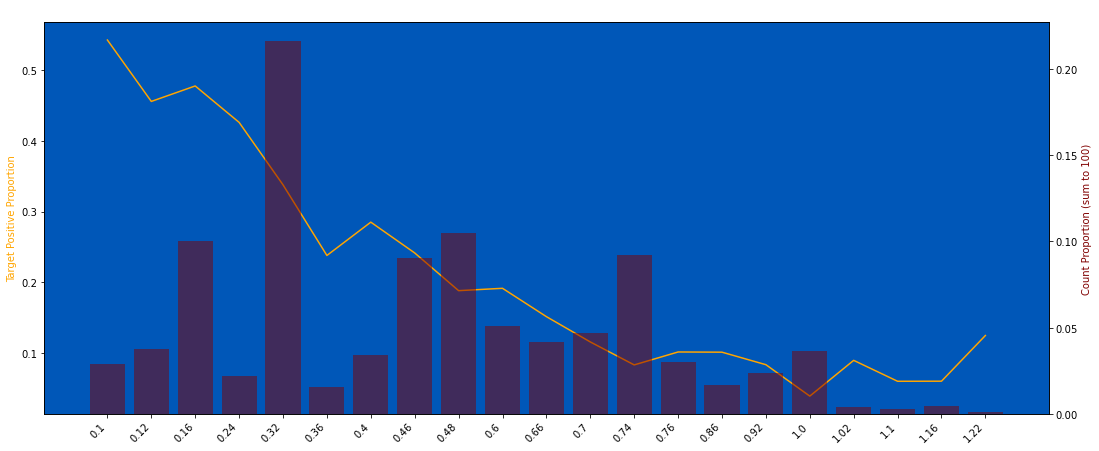

In [72]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [73]:
# plot_train_test_distribution(df_list, "S_8", nunique_thr=500, without_drop_tail=True)

### S_9 (Drop due to train test drift)

In [74]:
# plot_target_check(train, "S_9", q=50, use_raw_bin=True)

In [75]:
df_list = round_dfs(df_list, col="S_9", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.2505
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.2401


In [76]:
print_percentile(df_list, "S_9", 99)
describe_all(df_list, "S_9")

99th percentile:
train : 1.0
public test : 0.93
private test : 0.89


,train,public test,private test
count,"2,597,808.0000","3,312,481.0000","4,065,907.0000"
mean,0.0694,0.0610,0.0548
std,0.1960,0.1837,0.1798
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0100,0.0100
75%,0.0500,0.0400,0.0300
max,2.8300,2.8300,2.8300
null_proportion,0.5304,0.4208,0.2796


In [77]:
for df in df_list:
    df = clip_col(df, "S_9", top_value=1, add_new_col=False)

Train-Public PSI: 0.0533, Train-Private PSI: 0.2400
Bottom 1% and Top 1% are dropped from this chart


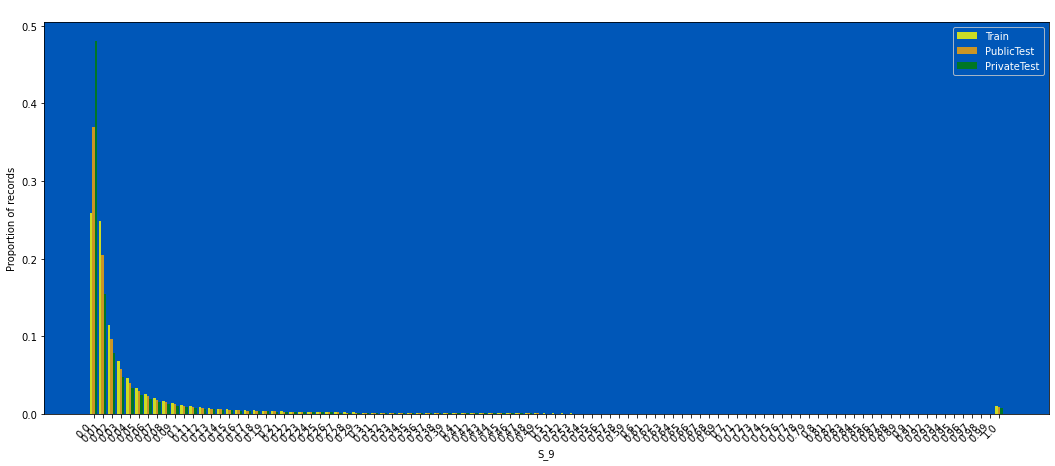

In [78]:
plot_train_test_distribution(df_list, "S_9", nunique_thr=300)

In [79]:
for df in tqdm(df_list):
    df.drop(columns="S_9", errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.85s/it]


### S_11 (Drop due to train test drift)

In [80]:
# plot_target_check(train, "S_11", q=50, use_raw_bin=True)

In [81]:
df_list = round_dfs(df_list, col="S_11", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 1.2048
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 1.1845


In [82]:
# plot_target_check(train, "S_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [83]:
for df in df_list:
    df["S_11"] = (df["S_11"] / 0.04).round(0)

In [84]:
# s11_min_max_df = train.groupby("customer_ID").agg(
#     s11_max=("S_11", "max"), 
#     s11_min=("S_11", "min")
# )
# t = s11_min_max_df.loc[s11_min_max_df["s11_max"] == s11_min_max_df["s11_min"]]
# sus_cid_list = t.loc[t["s11_max"] == 7].index.tolist()
# train.loc[train["customer_ID"].isin(sus_cid_list), "S_11"] = np.nan

In [85]:
# plot_target_check(train, "S_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [86]:
# plot_train_test_distribution(df_list, "S_11", nunique_thr=50000)

In [87]:
for df in tqdm(df_list):
    df.drop(columns="S_11", errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.00s/it]


### S_12 (Done)

In [88]:
# plot_target_check(train, "S_12", q=50, use_raw_bin=True)

In [89]:
%%time
df_list = round_dfs(df_list, col="S_12", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0513
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0500
CPU times: user 2.57 s, sys: 1.58 s, total: 4.15 s
Wall time: 7.01 s


In [90]:
print_percentile(df_list, "S_12", 0.01)
describe_all(df_list, "S_12")

0.01th percentile:
train : -0.36
public test : -0.36
private test : -0.35


,train,public test,private test
count,"5,531,451.0000","5,718,319.0000","5,643,058.0000"
mean,0.2355,0.2356,0.2368
std,0.2507,0.2546,0.2557
min,-0.4100,-0.4100,-0.4100
25%,0.1800,0.1800,0.1800
50%,0.1900,0.1900,0.1900
75%,0.2000,0.2000,0.2100
max,175.3300,192.6200,159.6400
null_proportion,0.0000,0.0002,0.0002


In [91]:
for df in df_list:
    df = clip_col(df, "S_12", top_value=1, add_new_col=False)
    df = clip_col(df, "S_12", btm_value=-0.36, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


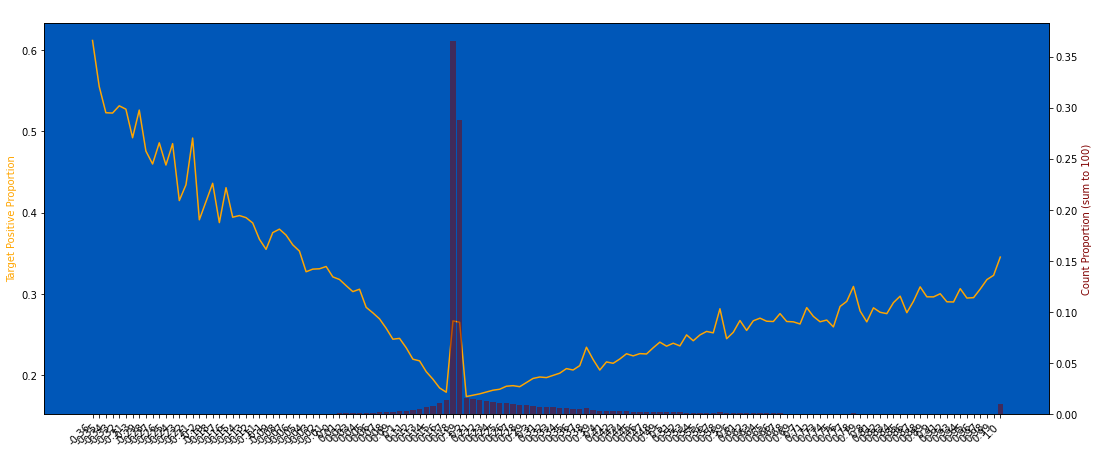

In [92]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [93]:
# plot_train_test_distribution(df_list, "S_12", nunique_thr=50000)

### S_13 (Done)

In [94]:
# plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

In [95]:
%%time
df_list = round_dfs(df_list, col="S_13", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1197
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1181
CPU times: user 2.39 s, sys: 1.73 s, total: 4.12 s
Wall time: 6.75 s


In [96]:
mapping_dict = {0.03: 1, 0.04: 1, 0.28: 2, 0.29: 2, 0.4 : 3, 0.41: 3, 0.42: 3, 0.43: 3, 
                0.5 : 4, 0.51: 4, 0.52: 5, 0.53: 5, 0.55: 6, 0.56: 6, 0.62: 7, 0.63: 7, 
                0.67: 8, 0.68: 8, 0.69: 9, 0.84: 10, 0.85: 10, 1: 11}

In [97]:
for df in df_list:
    df["S_13"] = df["S_13"].map(mapping_dict)

2822865 null count, 0.510 null proportion
0.2769 of the targets have label = 1


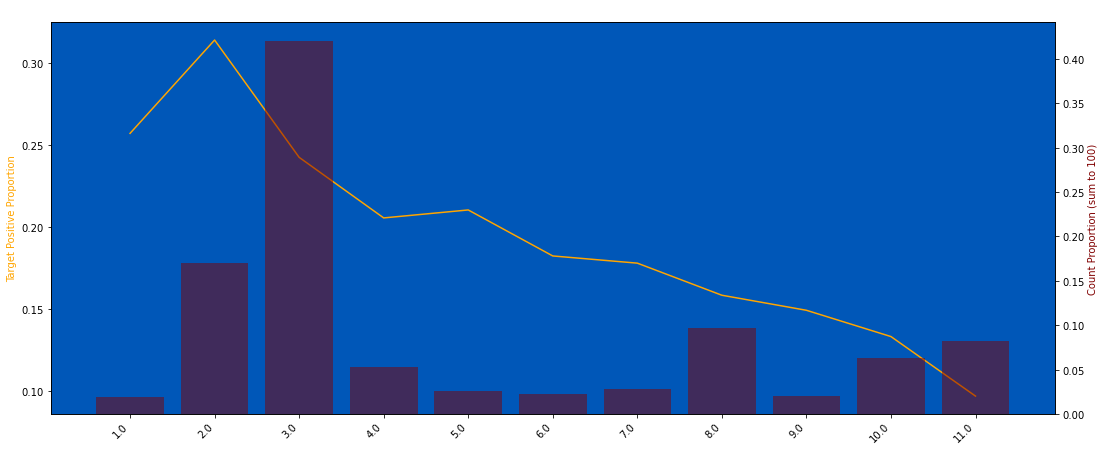

In [98]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [99]:
# plot_train_test_distribution(df_list, "S_13", nunique_thr=50000)

### S_15 (Done)

In [100]:
# plot_target_check(train, "S_15", q=50, use_raw_bin=True)

In [101]:
%%time
df_list = round_dfs(df_list, col="S_15", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.3584
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.3534
CPU times: user 2.34 s, sys: 1.82 s, total: 4.16 s
Wall time: 5.83 s


In [102]:
# for df in df_list:
#     df.loc[df["S_15"].between(0.5, 0.51), "S_15"] = np.nan

In [103]:
# for col in train.columns[2:]:
#     if col == "temp":
#         continue
#     corrcoef = train[["S_15_", col]].dropna().corr().iloc[0, 1]
#     if abs(corrcoef) >= 0.3:
#         print(col, corrcoef)

**Comments:**
- S_8 has the highest (absolute) correlation with S_15, use this information to cross validate the 0.5 - 0.51

In [104]:
train["S_8"].describe()

count   3,722,971.0000
mean            0.4774
std             0.2479
min             0.1000
25%             0.3200
50%             0.4600
75%             0.7000
max             1.2200
Name: S_8, dtype: float64

In [105]:
train.loc[train["S_8"].isnull(), "S_15"].describe()

count   1,808,480.0000
mean            0.5212
std             0.1140
min             0.5000
25%             0.5000
50%             0.5000
75%             0.5000
max             5.3000
Name: S_15, dtype: float64

In [106]:
np.percentile(train.loc[train["S_8"].isnull(), "S_15"].dropna(), 0)

0.5

In [107]:
np.percentile(train.loc[train["S_8"].isnull(), "S_15"].dropna(), 95)

0.6

**Comments:**
- When S_8 is null, S_15 is likely to be 0.5 (about 93% of them)
- Replace those S_15 (0.5 - 0.51) with NaN

In [108]:
for df in df_list:
    df.loc[df["S_8"].isnull(), "S_15"] = np.nan

In [109]:
for df in df_list:
    df["S_15"] = df["S_15"].abs()

In [110]:
print_percentile(df_list, "S_15", 99.9)
describe_all(df_list, "S_15")

99.9th percentile:
train : 1.5
public test : 1.5
private test : 1.6


,train,public test,private test
count,"3,722,971.0000","3,948,039.0000","3,990,462.0000"
mean,0.2982,0.2863,0.2802
std,0.1804,0.1819,0.1824
min,0.0000,0.0000,0.0000
25%,0.2000,0.2000,0.2000
50%,0.3000,0.3000,0.3000
75%,0.4000,0.4000,0.4000
max,5.3000,7.0000,8.3000
null_proportion,0.3269,0.3097,0.2930


In [111]:
for df in df_list:
    df = clip_col(df, "S_15", top_value=1.6, add_new_col=False)

1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1


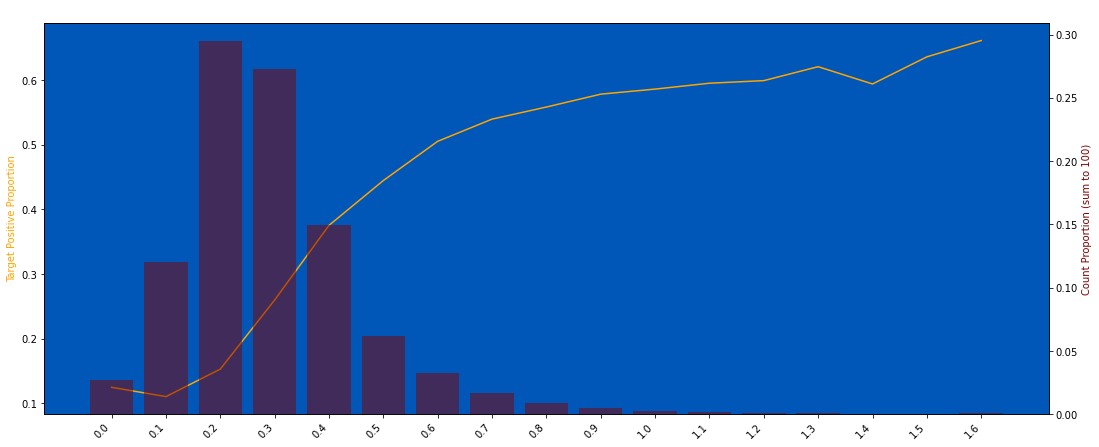

In [112]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [113]:
# plot_train_test_distribution(df_list, "S_15", nunique_thr=500, without_drop_tail=True)

### S_16 (Done)

In [114]:
# plot_target_check(train, "S_16", q=50, use_raw_bin=True)

In [115]:
%%time
df_list = round_dfs(df_list, col="S_16", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1060
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1048
CPU times: user 2.31 s, sys: 2.11 s, total: 4.42 s
Wall time: 5.29 s


In [116]:
print_percentile(df_list, "S_16", 99)
describe_all(df_list, "S_16")

99th percentile:
train : 1.0
public test : 0.87
private test : 0.64


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0458,0.0487,0.0457
std,0.7725,0.8653,0.9164
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,231.7500,236.3500,365.1700
null_proportion,0.0000,0.0000,0.0000


In [117]:
for df in df_list:
    df = clip_col(df, "S_16", top_value=1, add_new_col=False)
    df["S_16"] = df["S_16"].replace(0, np.nan)

5418175 null count, 0.980 null proportion
0.2390 of the targets have label = 1


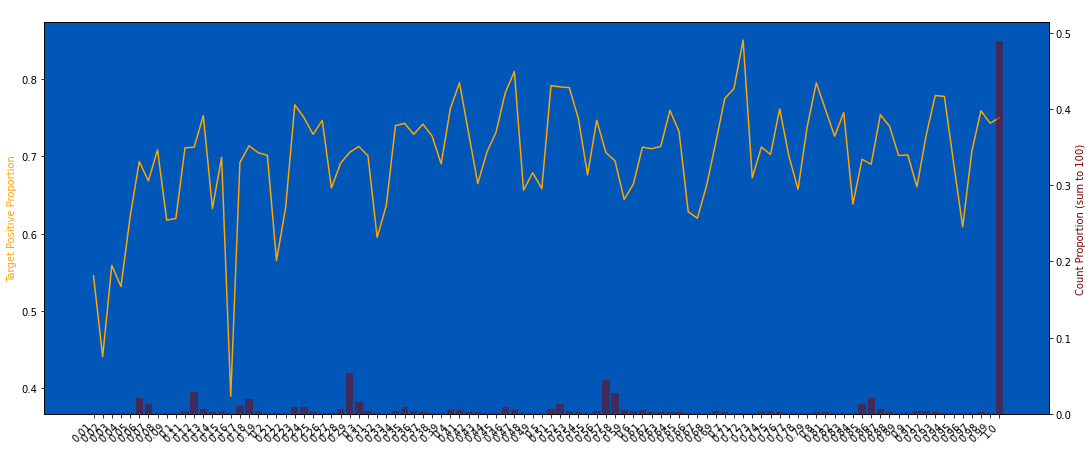

In [118]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [119]:
# plot_train_test_distribution(df_list, "S_16", nunique_thr=5000)

### S_17 (Drop)

In [120]:
# plot_target_check(train, "S_17", q=50, use_raw_bin=True)

In [121]:
%%time
df_list = round_dfs(df_list, col="S_17", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0465
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0461
CPU times: user 2.17 s, sys: 1.63 s, total: 3.8 s
Wall time: 6.77 s


In [122]:
# plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [123]:
df_list = fill_nans(df_list, col="S_17", method="point", tuple_of_values=(0), add_new_col=False)

In [124]:
# plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

In [125]:
# plot_train_test_distribution(
#     [
#         train.loc[train["S_17"] <= 1], 
#         public_test.loc[public_test["S_17"] <= 1],
#         private_test.loc[private_test["S_17"] <= 1]
#     ],
#     "S_17", 
#     nunique_thr=15000,
#     without_drop_tail=True
# )

In [126]:
for df in tqdm(df_list):
    df.drop(columns="S_17", errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]


### S_18 (Done)

In [127]:
# plot_target_check(train, "S_18", q=50, use_raw_bin=True)

In [128]:
%%time
df_list = round_dfs(df_list, col="S_18", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0001
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0001
CPU times: user 2.13 s, sys: 1.46 s, total: 3.59 s
Wall time: 5.17 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


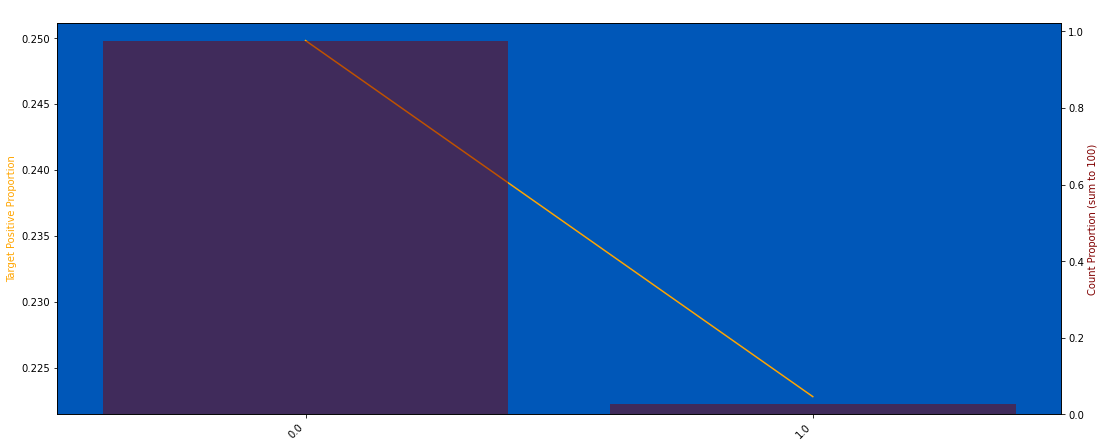

In [129]:
plot_target_check(train, "S_18", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True, without_drop_tail=True)

In [130]:
# plot_train_test_distribution(df_list, "S_18", nunique_thr=150, without_drop_tail=True)

### S_19 (Drop)

In [131]:
# plot_target_check(train, "S_19", q=50, use_raw_bin=True)

In [132]:
%%time
df_list = round_dfs(df_list, col="S_19", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0502
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0117
CPU times: user 2.35 s, sys: 2.21 s, total: 4.56 s
Wall time: 5.11 s


In [133]:
for df in df_list:
    print(df["S_19"].mean())

2.7790176573923133e-05
2.6741993006693942e-05
2.6708393770487004e-05


In [134]:
%%time
for df in df_list:
    df.drop(columns=["S_19"], inplace=True)

CPU times: user 685 ms, sys: 2.1 s, total: 2.78 s
Wall time: 4.31 s


### S_20 (Done Binary)

In [135]:
# plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=200)

In [136]:
%%time
df_list = round_dfs(df_list, col="S_20", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0010
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0010
CPU times: user 2.16 s, sys: 1.52 s, total: 3.68 s
Wall time: 5.44 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


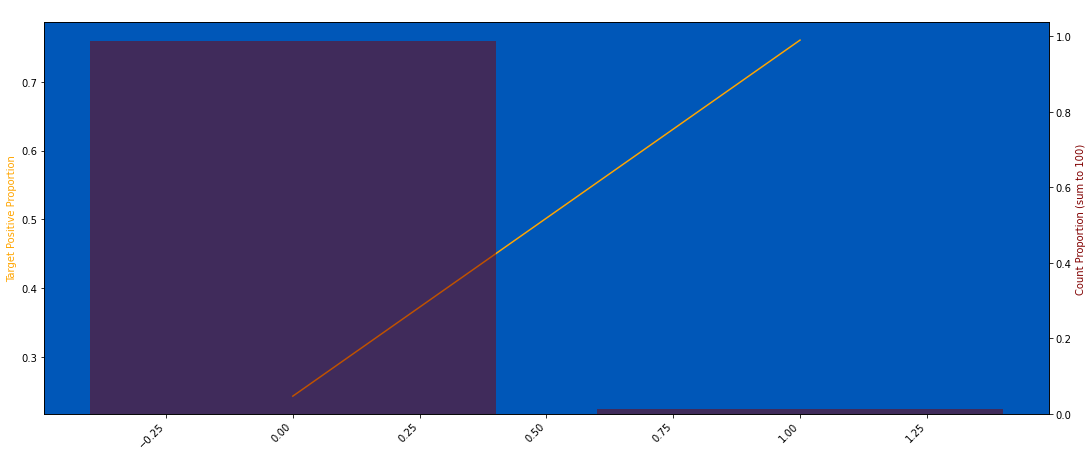

In [137]:
plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=2000, without_drop_tail=True)

In [138]:
# plot_train_test_distribution(df_list, "S_20", nunique_thr=50, without_drop_tail=True)

### S_22

In [139]:
# plot_target_check(train, "S_22", q=50, use_raw_bin=True)

In [140]:
%%time
df_list = round_dfs(df_list, col="S_22", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1080
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1141
CPU times: user 2.57 s, sys: 2.66 s, total: 5.23 s
Wall time: 6.26 s


In [141]:
print_percentile(df_list, "S_22", 0.2)
describe_all(df_list, "S_22")

0.2th percentile:
train : 0.0
public test : 0.0
private test : 0.0


,train,public test,private test
count,"5,512,427.0000","5,688,148.0000","5,614,406.0000"
mean,0.7741,0.7856,0.7898
std,0.7188,0.7101,0.7949
min,-92.0000,-92.0000,-92.0000
25%,0.8100,0.8600,0.8700
50%,0.9400,0.9400,0.9400
75%,0.9600,0.9600,0.9600
max,1.0300,1.0300,1.0300
null_proportion,0.0034,0.0055,0.0053


In [142]:
for df in df_list:
    df = clip_col(df, "S_22", top_value=1.02, add_new_col=False)
    df = clip_col(df, "S_22", btm_value=0, add_new_col=False)

19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1


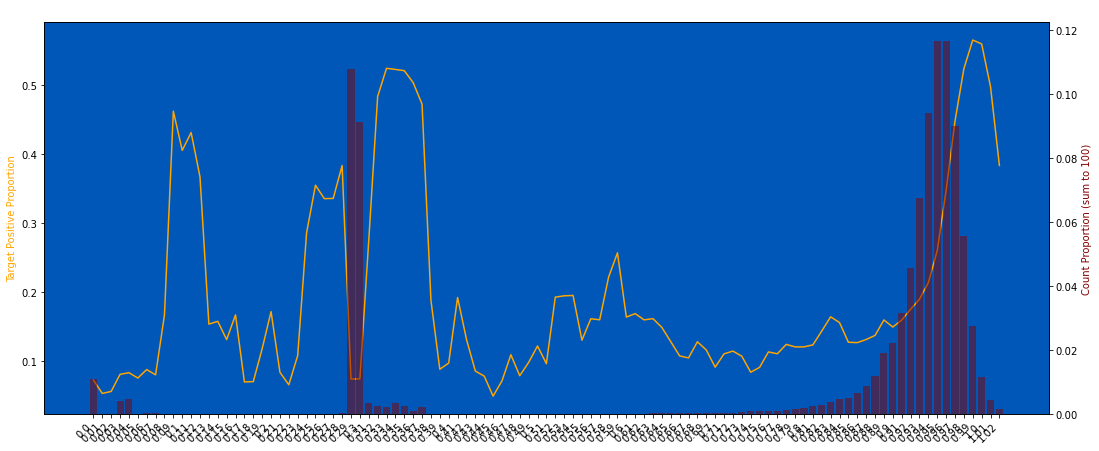

In [143]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True, nunique_thr=777, strfy_x=True)

Train-Public PSI: 0.0956, Train-Private PSI: 0.1099
Bottom 1% and Top 1% are dropped from this chart


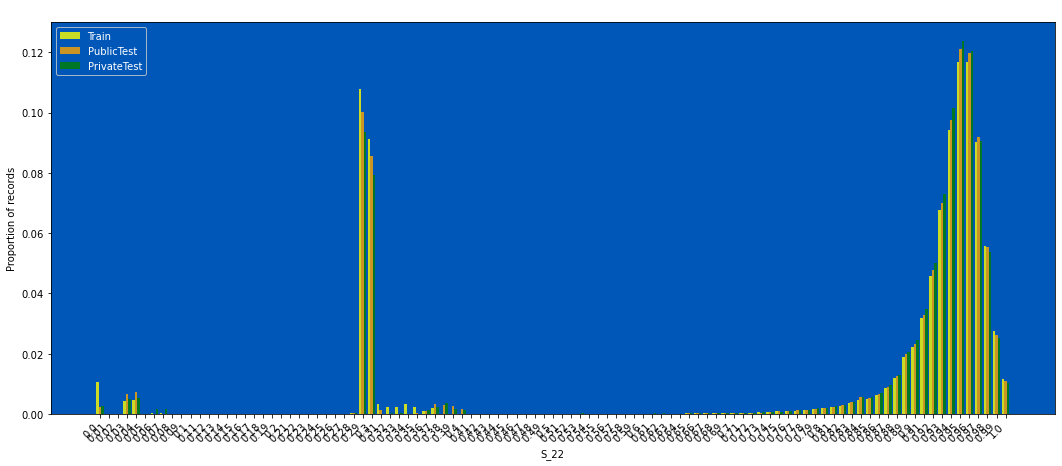

In [144]:
plot_train_test_distribution(df_list, "S_22", nunique_thr=777)

### S_23

In [145]:
# plot_target_check(train, "S_23", q=50, use_raw_bin=True)

In [146]:
%%time
df_list = round_dfs(df_list, col="S_23", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0573
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0573
CPU times: user 2.22 s, sys: 1.41 s, total: 3.62 s
Wall time: 5.48 s


In [147]:
print_percentile(df_list, "S_23", 99.8)
describe_all(df_list, "S_23")

99.8th percentile:
train : 1.49
public test : 1.49
private test : 1.53


,train,public test,private test
count,"5,531,006.0000","5,718,672.0000","5,643,549.0000"
mean,0.1747,0.1792,0.1811
std,0.8520,0.7962,0.8180
min,-206.0900,-446.9600,-338.9300
25%,0.1300,0.1300,0.1300
50%,0.1300,0.1300,0.1300
75%,0.1300,0.1300,0.1300
max,885.3300,930.1600,819.0400
null_proportion,0.0001,0.0001,0.0001


In [148]:
for df in df_list:
    df = clip_col(df, "S_23", top_value=1.5, add_new_col=False)
    df = clip_col(df, "S_23", btm_value=-0.6, add_new_col=False)

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


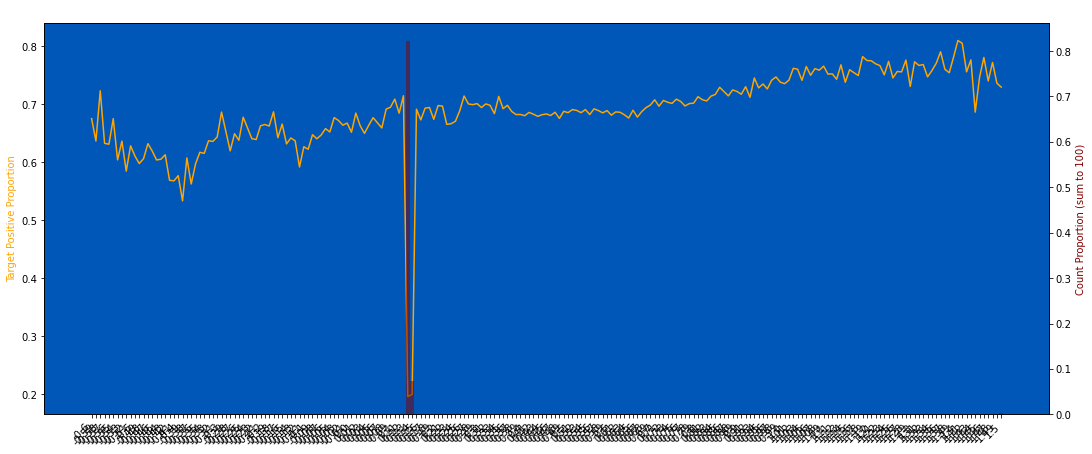

In [149]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1600)

In [150]:
# plot_train_test_distribution(df_list, "S_23", nunique_thr=1600)

### S_24 (Drop)

In [151]:
# plot_target_check(train, "S_24", q=50, use_raw_bin=True)

In [152]:
%%time
df_list = round_dfs(df_list, col="S_24", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0762
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0778
CPU times: user 2.39 s, sys: 1.59 s, total: 3.97 s
Wall time: 6.67 s


In [153]:
print_percentile(df_list, "S_24", 0.15)
describe_all(df_list, "S_24")

0.15th percentile:
train : 0.0
public test : 0.0
private test : -0.13


,train,public test,private test
count,"5,512,858.0000","5,688,629.0000","5,614,977.0000"
mean,0.7299,0.7463,0.7570
std,0.8357,0.8258,0.8622
min,-90.4900,-90.4900,-90.4900
25%,0.8000,0.8600,0.8700
50%,0.9400,0.9500,0.9500
75%,0.9700,0.9700,0.9700
max,1.0500,1.0500,1.0500
null_proportion,0.0034,0.0054,0.0052


In [154]:
for df in df_list:
    df = clip_col(df, "S_24", top_value=1.02, add_new_col=False)
    df = clip_col(df, "S_24", btm_value=0, add_new_col=False)

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1


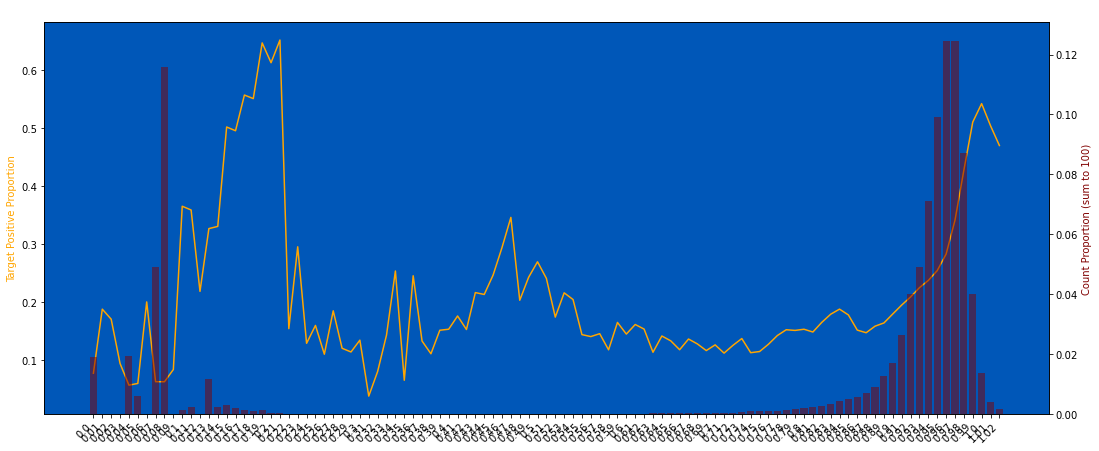

In [155]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True, nunique_thr=650, strfy_x=True)

Train-Public PSI: 0.0666, Train-Private PSI: 0.3672
Bottom 1% and Top 1% are dropped from this chart


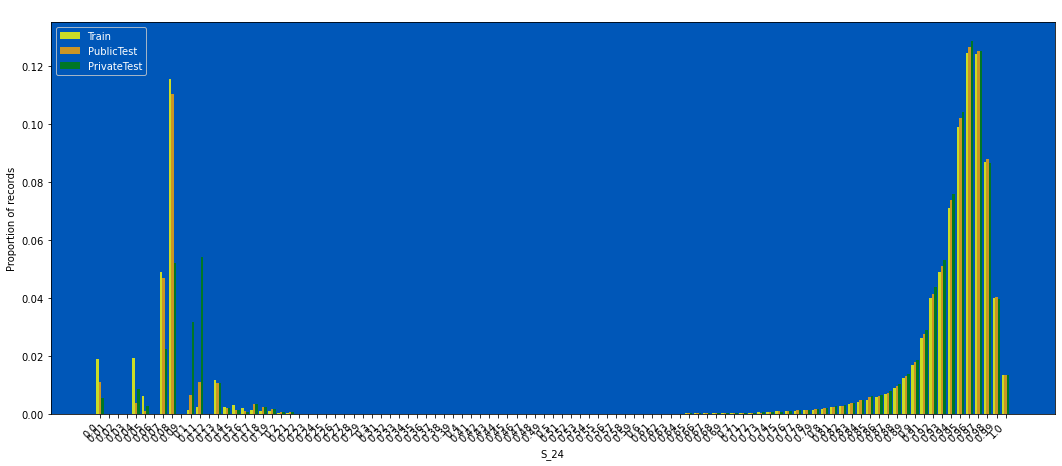

In [156]:
plot_train_test_distribution(df_list, "S_24", nunique_thr=650)

In [157]:
%%time
for df in df_list:
    df.drop(columns=["S_24"], inplace=True)

CPU times: user 688 ms, sys: 1.56 s, total: 2.25 s
Wall time: 2.78 s


### S_25

In [158]:
# plot_target_check(train, "S_25", q=50, use_raw_bin=True)

In [159]:
%%time
df_list = round_dfs(df_list, col="S_25", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0591
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0384
CPU times: user 2.23 s, sys: 1.29 s, total: 3.52 s
Wall time: 4.85 s


In [160]:
print_percentile(df_list, "S_25", 0.1)
describe_all(df_list, "S_25")

0.1th percentile:
train : -1.19
public test : -1.19
private test : -1.19


,train,public test,private test
count,"5,518,604.0000","5,706,483.0000","5,630,967.0000"
mean,0.9200,0.9182,0.9218
std,0.2068,0.2117,0.2065
min,-2.4600,-2.4600,-2.4600
25%,0.9700,0.9700,0.9700
50%,0.9700,0.9700,0.9700
75%,0.9700,0.9700,0.9700
max,4.0500,3.6700,5.6000
null_proportion,0.0023,0.0023,0.0024


In [161]:
for df in df_list:
    df = clip_col(df, "S_25", top_value=1.38, add_new_col=False)
    df = clip_col(df, "S_25", btm_value=-1.19, add_new_col=False)

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


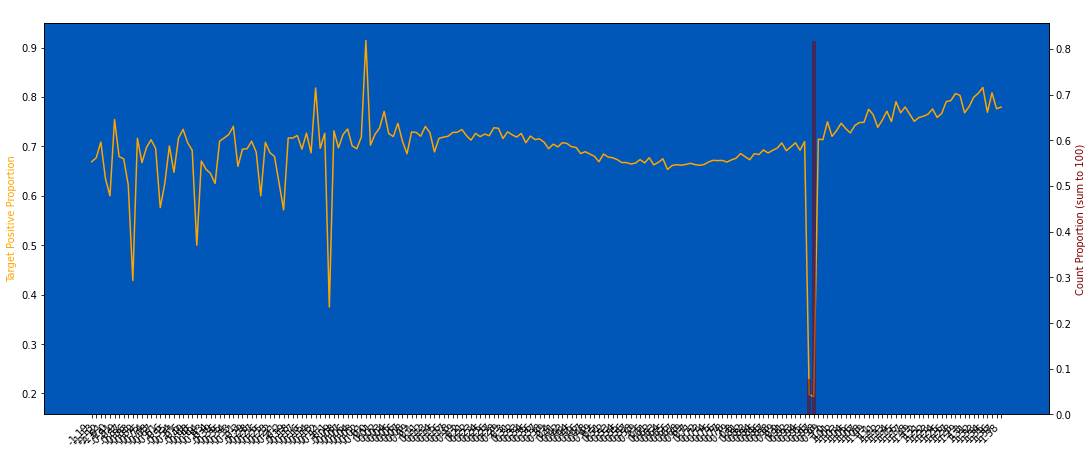

In [162]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [163]:
# plot_train_test_distribution(df_list, "S_25", nunique_thr=1500)

### S_26 (Done)

In [164]:
# plot_target_check(train, "S_26", q=50, use_raw_bin=True)

In [165]:
%%time
df_list = round_dfs(df_list, col="S_26", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1113
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1128
CPU times: user 2.11 s, sys: 1.12 s, total: 3.24 s
Wall time: 4.26 s


In [166]:
print_percentile(df_list, "S_26", 99.8)
describe_all(df_list, "S_26")

99.8th percentile:
train : 2.74
public test : 2.8549399999994782
private test : 3.08


,train,public test,private test
count,"5,530,817.0000","5,717,254.0000","5,642,742.0000"
mean,0.0618,0.0669,0.0737
std,0.4638,0.5372,0.5213
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0100,0.0100,0.0200
max,136.6600,272.0500,186.6300
null_proportion,0.0001,0.0004,0.0003


In [167]:
for df in df_list:
    df = clip_col(df, "S_26", top_value=2.5, add_new_col=False)

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1


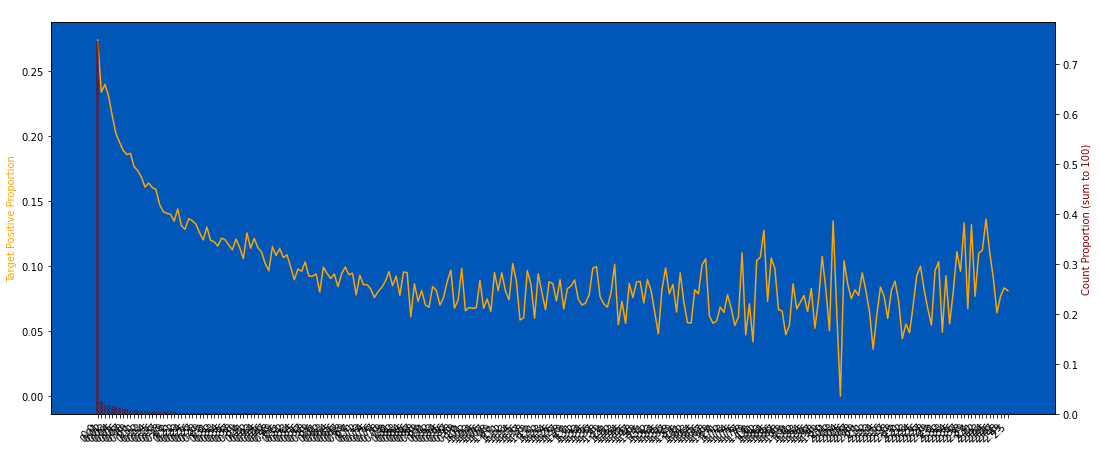

In [168]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

In [169]:
# plot_train_test_distribution(df_list, "S_26", nunique_thr=2000)

### S_27

In [170]:
# plot_target_check(train, "S_27", q=50, use_raw_bin=True)

In [171]:
%%time
df_list = round_dfs(df_list, col="S_27", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1126
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1025
CPU times: user 2.1 s, sys: 1.38 s, total: 3.48 s
Wall time: 5.2 s


In [172]:
print_percentile(df_list, "S_27", 99.2)
describe_all(df_list, "S_27")

99.2th percentile:
train : 1.08
public test : 1.48
private test : 1.18


,train,public test,private test
count,"4,130,516.0000","4,409,930.0000","4,453,557.0000"
mean,0.2730,0.3185,0.3132
std,0.3250,0.3747,0.3390
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.2900,0.3400,0.3500
75%,0.4400,0.5100,0.5100
max,5.4500,5.4500,5.4500
null_proportion,0.2533,0.2290,0.2110


In [173]:
for df in df_list:
    df = clip_col(df, "S_27", top_value=1.2, add_new_col=False)

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1


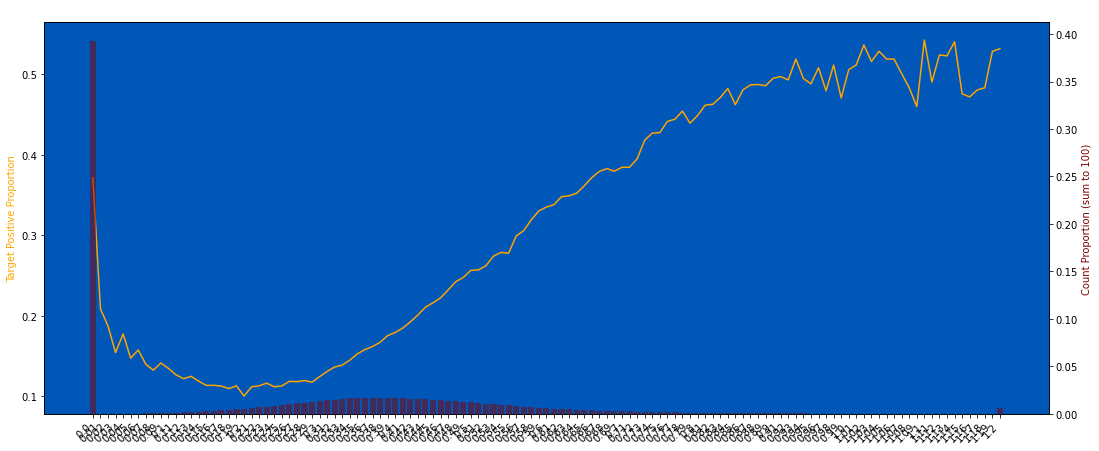

In [174]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

## Spike fix

S_12
0 null count, 0.000 null proportion
nan of the targets have label = 1


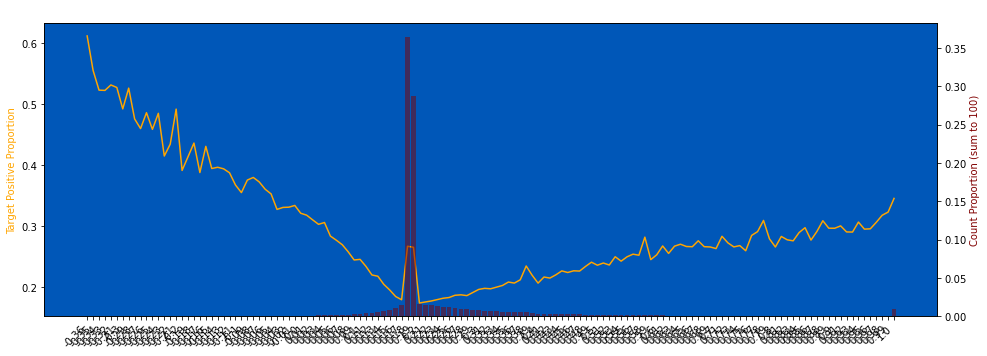

S_23
445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


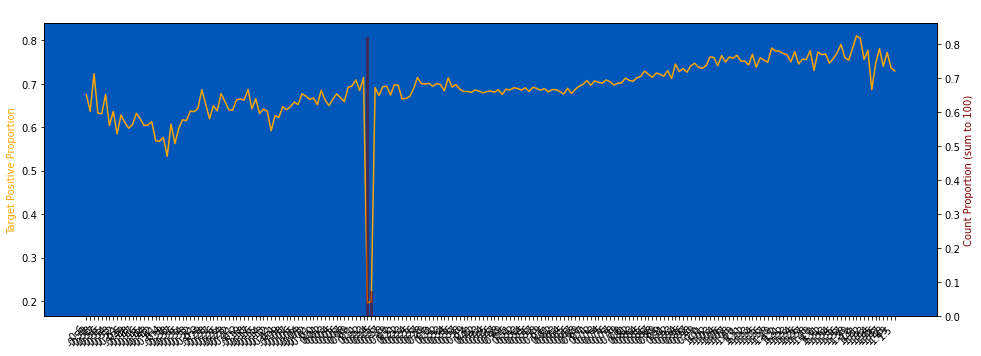

S_25
12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


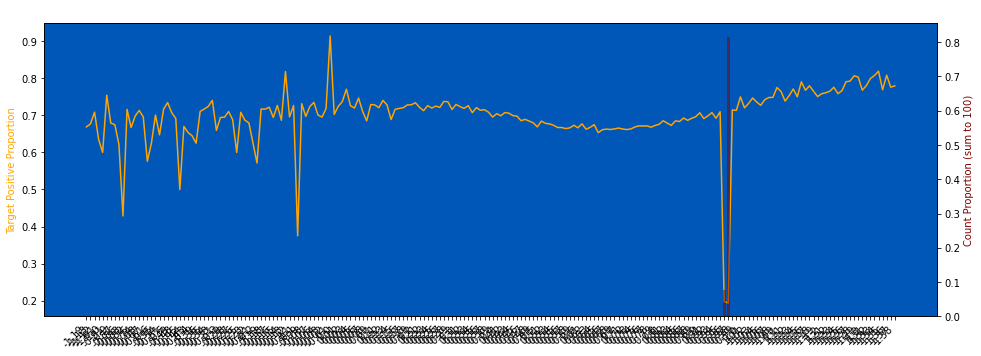

In [175]:
for col in ["S_12", "S_23", "S_25"]:
    print(col)
    plot_target_check(train, col, q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, figsize=(16, 6))

### S_12

In [176]:
special_indices = train.loc[
    (train["S_12"].between(0.18, 0.19))
    & 
    ~(
        (train["S_23"].between(0.13, 0.14))
        | (train["S_25"].between(0.96, 0.97))
    )
    
].index.tolist()

In [177]:
# train["S_12_"] = train["S_12"].values
train.loc[special_indices, "S_12"] = np.nan

362113 null count, 0.065 null proportion
0.7413 of the targets have label = 1


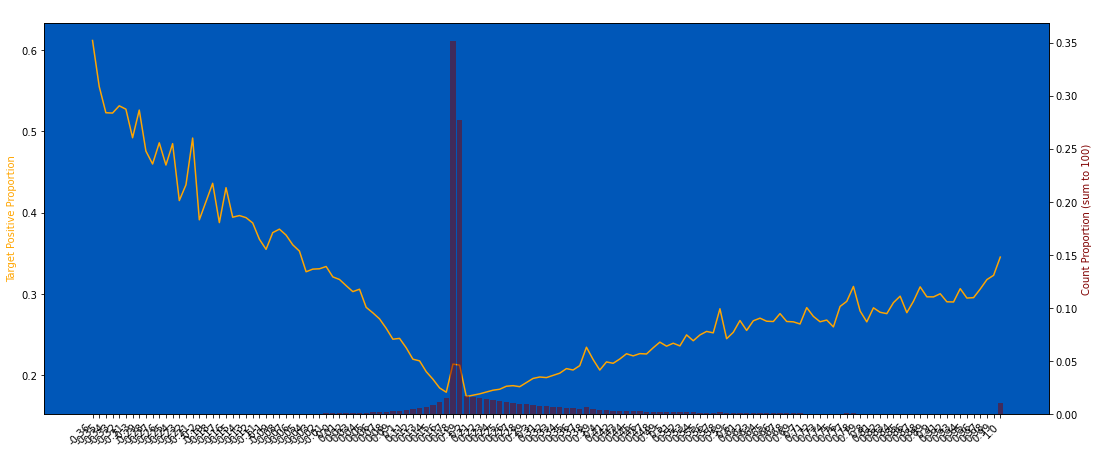

In [178]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

### S_23

In [179]:
special_indices = train.loc[
    (train["S_23"].between(0.13, 0.14))
    & 
    (
        (train["S_12"].isnull())
        | (train["S_22"].between(0.3, 0.31))
        | (train["S_25"].between(0.96, 0.97))
    )
    
].index.tolist()

In [180]:
# train["S_23_"] = train["S_23"].values
train.loc[special_indices, "S_23"] = np.nan

4915198 null count, 0.889 null proportion
0.1929 of the targets have label = 1


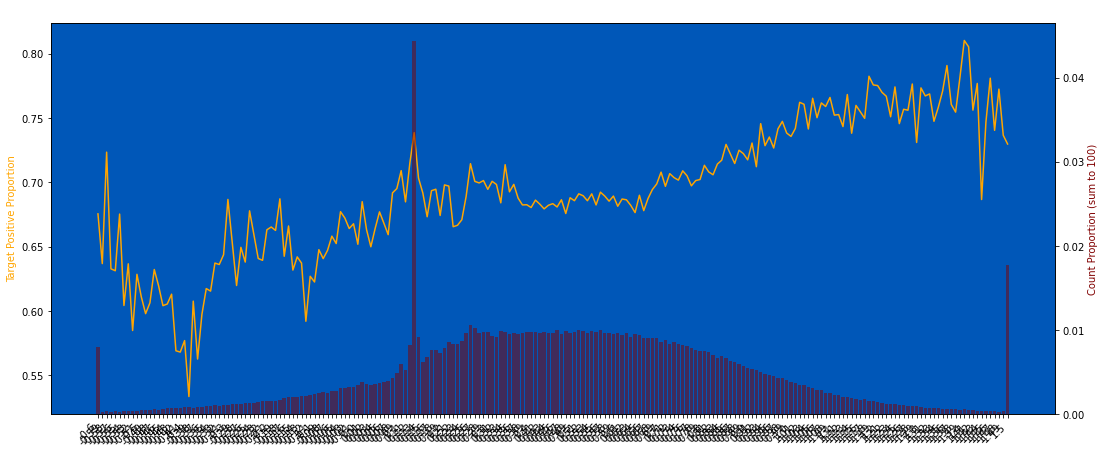

In [181]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

### S_25

In [182]:
special_indices = train.loc[
    (train["S_25"].between(0.96, 0.97))
    & 
    (
        (train["S_12"].isnull())
        | (train["S_22"].between(0.3, 0.31))
        | (train["S_23"].isnull())
    )
    
].index.tolist()

In [183]:
# train["S_25_"] = train["S_25"].values
train.loc[special_indices, "S_25"] = np.nan

4927576 null count, 0.891 null proportion
0.1941 of the targets have label = 1


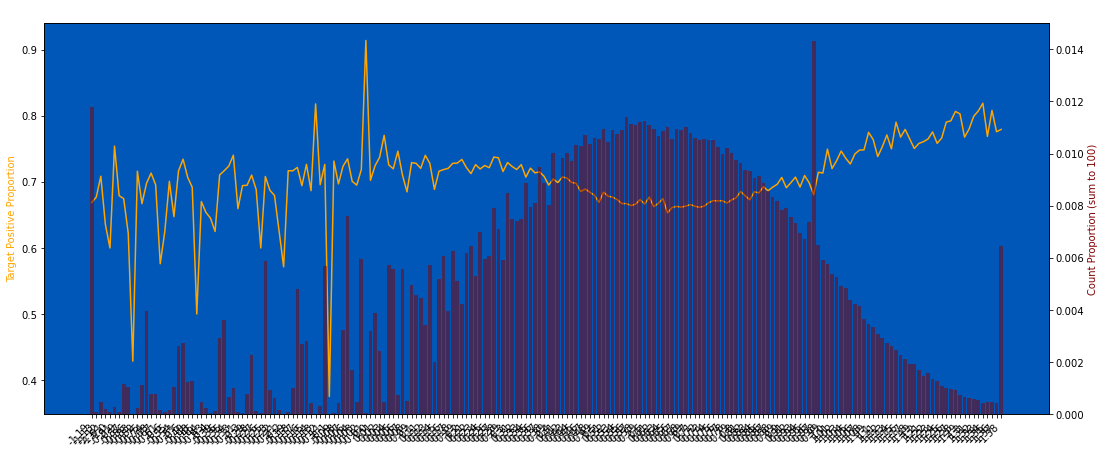

In [184]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [185]:
END = time.time()

In [186]:
print(f"{END - START:.2f} seconds elapsed")

349.37 seconds elapsed


### Column checking

In [187]:
from tqdm import tqdm

In [190]:
all_columns = get_cols(df_list[0], ("S_", "P_"))
print(all_columns)

['S_2', 'P_2', 'S_3', 'P_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_12', 'S_13', 'S_15', 'P_4', 'S_16', 'S_18', 'S_20', 'S_22', 'S_23', 'S_25', 'S_26', 'S_27', 'P_3a']


In [191]:
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 200].index.tolist()

In [192]:
for col in tqdm(less_unique_d_cols):
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

 35%|███████████████████████████████████████████████▋                                                                                       | 6/17 [00:00<00:00, 27.56it/s]

S_6 fulfill criteria to convert to integer
S_13 fulfill criteria to convert to integer


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 12/17 [00:01<00:00, 10.98it/s]

S_18 fulfill criteria to convert to integer
S_20 fulfill criteria to convert to integer


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  8.59it/s]


In [193]:
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

P_2 fulfill criteria to convert to float32
S_3 fulfill criteria to convert to float32
P_3 fulfill criteria to convert to float32
S_5 fulfill criteria to convert to float32
S_7 fulfill criteria to convert to float32
S_8 fulfill criteria to convert to float32
S_12 fulfill criteria to convert to float32
S_15 fulfill criteria to convert to float32
P_4 fulfill criteria to convert to float32
S_16 fulfill criteria to convert to float32
S_22 fulfill criteria to convert to float32
S_23 fulfill criteria to convert to float32
S_25 fulfill criteria to convert to float32
S_26 fulfill criteria to convert to float32
S_27 fulfill criteria to convert to float32
P_3a fulfill criteria to convert to float32


In [213]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp']

In [214]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.21it/s]

CPU times: user 412 ms, sys: 530 ms, total: 942 ms
Wall time: 940 ms


### Verify if all columns have been clipped

In [215]:
for col in tqdm(df_list[0].columns):
    if col in NON_FEATURE_COLUMNS:
        continue
    if not (df_list[0][col].min() == df_list[1][col].min() == df_list[2][col].min()):
        print(f"Min of column {col} is different: {df_list[0][col].min()}, {df_list[1][col].min()}, {df_list[2][col].min()}")
    
    if not (df_list[0][col].max() == df_list[1][col].max() == df_list[2][col].max()):
        print(f"Max of column {col} is different: {df_list[0][col].max()}, {df_list[1][col].max()}, {df_list[2][col].max()}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 30.70it/s]


In [216]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 3.5 s, sys: 1.13 s, total: 4.63 s
Wall time: 4.75 s


In [217]:
train.shape, test.shape

((5531451, 25), (11363762, 24))

In [218]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

(1.468346051, 2.556846594)

In [219]:
train.columns

Index(['customer_ID', 'row_number', 'row_number_inv', 'S_2', 'P_2', 'S_3',
       'P_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_12', 'S_13', 'S_15', 'P_4',
       'S_16', 'S_18', 'S_20', 'S_22', 'S_23', 'S_25', 'S_26', 'S_27',
       'target', 'P_3a'],
      dtype='object')

In [220]:
%%time
train.to_parquet(f"./train_parquet/train_spend_payment_.parquet")
test.to_parquet(f"./test_parquet/test_spend_payment_.parquet")

CPU times: user 7.47 s, sys: 588 ms, total: 8.06 s
Wall time: 7.38 s
